<a href="https://colab.research.google.com/github/JayBlaine/WSBAI/blob/main/WSBAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regression model

### **DO NOT RUNTIME->RUN ALL, WILL CRASH RUNTIME AT LIVE PRAW SCRAPE DUE TO MEMORY CONSRTAINTS, MUST RUN INDIVIDUALLY**

Code section for reading GMEs stock data


In [ ]:
!pip install asyncpraw
!pip install asyncio

Imports and getting stock data

In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import csv, math, os, random
# Linear Regression model
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf
# Reddit data scrape
import asyncpraw
import asyncio
import nest_asyncio
# Make numpy values easier to read.
# Other model
np.set_printoptions(precision=3, suppress=True)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

def main(): # Getting prices (only open, close, vol) for stock data for each day market is open
    stonk = "GME"
    start = dt.datetime(2021, 1, 1)
    end = dt.datetime.today()

    data = web.DataReader(stonk,'stooq', start, end).reset_index()
    data.drop('High', 1, inplace=True)
    data.drop('Low', 1, inplace=True)
    
    data = data.to_csv(r'./stonkdata.csv', index=False, header=True)
    
    
if __name__ == '__main__':
    main()

# Preparing data

In [ ]:
# WSB data set read (TRAINING DATA)

def gmeChecker(title, body): # checks if title or body of post contains any of these key words
  gmeKeys = ['gme', 'gamestop', 'dfv', 'deep fucking value', 'citadel', 'ken griffin', 'keith', 'gill', 'roaring kitty', 'if he\'s in', 'if hes in']
  title = title.strip().lower()
  body = body.strip().lower()
  for key in gmeKeys:
    # body and title
    if key in title or key in body:
      return True
  return False

def dateChecker(date1): # Cleans data from datetime to just date
  dtTemp = dt.datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')
  actDate = dtTemp.date()
  return actDate


# FOR READING INTO CLEAN DATASET, COMPARING DATE TO REDDIT DATE DICT
dateStockData = []
dateStockData = pd.read_csv('./stonkdata.csv', usecols=['Date', 'Open', 'Close'])
newD = pd.DataFrame(dateStockData)
newD = newD.iloc[::-1]
lineCount = len(dateStockData)

# date, reddit total posts, gme total posts, ratio of gme to total, 
# avg score of reddit posts, average score of gme posts, avg comments total, avg comments gme
byDate = {}

# https://www.kaggle.com/gpreda/reddit-wallstreetsbets-posts

with open('reddit_wsb.csv') as csv_file: # Stores post data in list to be parsed by date before checking if gme post or not
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  for row in csv_reader:
    if line_count > 1:
      tempTitle = row[0]
      tempScore = row[1]
      tempCommNum = row[4]
      tempBody = row[6]
      tempDate = row[7]
      tempPass = [tempTitle, tempScore, tempCommNum, tempBody, tempDate]
      date1 = dateChecker(tempDate) # Check the day of that post

      if date1 not in byDate.keys(): # if dictionary of posts for that day DNE, create key
        byDate[date1] = []
        byDate[date1].append(tempPass)
      else:                          # else, append
        byDate[date1].append(tempPass)
    line_count+=1

redditPrelim = []

for key in byDate.keys():
  if key.year < 2021: # Gets rid of rogue row at 9/2020
      continue
  i=0
  gmeCnt = 0
  gmeCommTotal = 0
  gmeUpTotal = 0
  while i < len(byDate[key]):
    gmeCheck = gmeChecker(byDate[key][i][0], byDate[key][i][3]) # Checks if GME keywords are mentioned in title of body
    if gmeCheck:
      gmeCnt+=1
      gmeCommTotal+=int(byDate[key][i][2])
      gmeUpTotal+=int(byDate[key][i][1])
    i+=1
  if i > 0 and gmeCnt > 0: # day has both posts and gme posts
    redditPrelim.append([key, i, gmeCnt, gmeCnt/i, gmeUpTotal/gmeCnt, gmeCommTotal/gmeCnt])
  elif i > 0: # no gme posts
    redditPrelim.append([key, i, gmeCnt, gmeCnt/i, 0, 0])
  else: # no posts
    continue


columns = dateStockData.filter(['Date']).values
with open('wsb_clean.csv', mode='w') as write_file:
  writer = csv.writer(write_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  i=0
  date=0
  #TODO
  writer.writerow(['Date', 'open', 'close', 'total posts', 'GME count', '% GME', 'avg GME upvotes', 'avg GME comments'])
  while i < len(redditPrelim):
    if str(redditPrelim[i][0]) in columns:
      writer.writerow([redditPrelim[i][0], dateStockData['Open'][date], dateStockData['Close'][date], redditPrelim[i][1], 
                       redditPrelim[i][2], redditPrelim[i][3], redditPrelim[i][4], redditPrelim[i][5]])
      date+=1
    i+=1



Reddit Data Scrape for practical evaluation

In [ ]:
# REDDIT EVAL DATA SCRAPE

async def reddo(posts):
  reddit = asyncpraw.Reddit(client_id='ORNE1J4ncT_tGg', client_secret= 'sa-2SPPkOY-w_kMIBSeAostYFg804Q', user_agent='WSBAI:Python/urllib:v0.0.1 (by u/WSBAI_00123)', 
                            username="WSBAI_00123", password="lint$h@d0w,./") # reddit account data
  wsb_sub = await reddit.subreddit('WallStreetBets') # subreddit to scrape
  
  i = 0
  # print(reddit.read_only)

  async for submission in wsb_sub.new(limit=600): # loop through 600 most recent posts in subreddit. breaks if too big
    posts.append([submission.title, submission.score, submission.num_comments, submission.selftext, submission.created])
  # print(len(posts))
  
  await reddit.close()
  return posts


posts = []
nest_asyncio.apply()
loop = asyncio.get_event_loop() 
posts = loop.run_until_complete(reddo(posts)) # stores list of most recent posts, runs async


test_eval = []
i=0
gmeCnt = 0
gmeCommTotal = 0
gmeUpTotal = 0

while i < len(posts):
  gmeCheck = gmeChecker(posts[i][0], posts[i][3]) # Checks if GME keywords are mentioned, function in above block
  if gmeCheck:
    gmeCnt+=1
    gmeCommTotal+=int(posts[i][2])
    gmeUpTotal+=int(posts[i][1])

  i+=1
if i > 0 and gmeCnt > 0: # both posts and gme posts
  test_eval = [dt.date.today(), dateStockData['Open'][0], dateStockData['Close'][0], i, gmeCnt, gmeCnt/i, gmeUpTotal/gmeCnt, gmeCommTotal/gmeCnt]
elif i > 0: # no gme posts
  test_eval= [dt.date.today(), dateStockData['Open'][0], dateStockData['Close'][0], i, gmeCnt, gmeCnt/i, 0, 0]
test_eval = pd.DataFrame([test_eval],columns=['Date', 'open', 'close', 'total posts', 'GME count', '% GME', 'avg GME upvotes', 'avg GME comments'])
test_eval.to_csv('eval.csv')

# print(test_eval)


# Creating guess for **Moon**

In [ ]:

fullFile = pd.read_csv('wsb_clean.csv')
testDataSize = len(fullFile)-1
# Load dataset.
dftrain = fullFile.head(testDataSize) # training data
dfeval = pd.read_csv('eval.csv') # testing data


dftrain.pop('Date') # redundant, leftover from scrape to combine two datasets
dfeval.pop('Date')
y_train = dftrain.pop('close') # goal column
y_eval = dfeval.pop('close')


dataCol = ['open', 'total posts', 'GME count', '% GME', 'avg GME upvotes', 'avg GME comments'] # numerical columns for daily metadata
featureCol = []
for feature in dataCol:
  featureCol.append(tf.feature_column.numeric_column(feature, dtype=tf.float32))


def make_input_fn(data, label, epochs=100, shuffle=True, batch=16):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data), label))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize data to prevent overfit
    ds = ds.batch(batch).repeat(epochs)  # split dataset into batches of 16 and repeat for num Epochs
    return ds  # return ds batch
  return input_function  # return inner function


train_input_fn = make_input_fn(dftrain, y_train)  # get dataset object to feed to model
eval_input_fn = make_input_fn(dfeval, y_eval, epochs=1, shuffle=False) # off shuffle since one col, 1 epoch to get prediction


linear_est = tf.estimator.LinearRegressor(feature_columns=featureCol)
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on eval data


clear_output()  # clears consoke output
# print(result)  # the result variable is simply a dict of stats about our model


pred_dicts = list(linear_est.predict(eval_input_fn))
prediction = pred_dicts[0]['predictions'][0]
# print(prediction)



INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpgp9iprh6/model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


# Creating guess for **Buffet**

*Credit for help: NeuralNine on YouTube*


In [ ]:
daysToPredict = 60
predictionLayers = 128


stonkData = pd.read_csv('./stonkdata.csv') # format = Date, Open, Close, Volume
stonkData = stonkData[0:(len(stonkData)-1)]

# Reading only the closing prices
stonkPrices = (stonkData.filter(['Close'])).values
dataLength = len(stonkPrices)

# Squash data
dataScaler = MinMaxScaler(feature_range=(0,1))
scaledData = dataScaler.fit_transform(stonkPrices).reshape(-1,1)

# Spliting up the data for x and y training
x_train = []
y_train = []

# Amount we wanted trained using the length of our data
# Starts from the days we want to predict to the end
for x in range(daysToPredict, dataLength):
  x_train.append(scaledData[x - daysToPredict:x, 0])
  y_train.append(scaledData[x, 0])
  # if x <= daysToPredict:
  #   print(f"X data-----------------\n{x_train}\nY data-----------------\n{y_train}")

x_train = np.array(x_train)
y_train = np.array(x_train)

# x_train = np.reshape(x_train, dataLength, daysToPredict, 1)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Creating the training the model

In [ ]:
# Building the model
model = Sequential()
model.add(LSTM(units=predictionLayers, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Dropout randomly inputs 0s to help against overfitting (at a rate of 0.2)
model.add(Dropout(0.2))
model.add(LSTM(units = predictionLayers))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=16, batch_size=8)

Epoch 1/16
3/3 [==============================] - 4s 98ms/step - loss: 0.1310
Epoch 2/16
3/3 [==============================] - 0s 98ms/step - loss: 0.0656
Epoch 3/16
3/3 [==============================] - 0s 97ms/step - loss: 0.0540
Epoch 4/16
3/3 [==============================] - 0s 88ms/step - loss: 0.0602
Epoch 5/16
3/3 [==============================] - 0s 84ms/step - loss: 0.0552
Epoch 6/16
3/3 [==============================] - 0s 94ms/step - loss: 0.0550
Epoch 7/16
3/3 [==============================] - 0s 84ms/step - loss: 0.0531
Epoch 8/16
3/3 [==============================] - 0s 91ms/step - loss: 0.0525
Epoch 9/16
3/3 [==============================] - 0s 87ms/step - loss: 0.0514
Epoch 10/16
3/3 [==============================] - 0s 89ms/step - loss: 0.0507
Epoch 11/16
3/3 [==============================] - 0s 88ms/step - loss: 0.0498
Epoch 12/16
3/3 [==============================] - 0s 89ms/step - loss: 0.0518
Epoch 13/16
3/3 [==============================] - 0s 90ms/st

Testing

In [ ]:
dataTest = pd.read_csv("./stonkdata.csv")
dataTest = dataTest.loc[::-1].reset_index(drop = True)
firstPart = dataTest['Close'].values

model_in = firstPart[len(stonkData) - daysToPredict:]
model_in = model_in.reshape(-1, 1)
model_in = dataScaler.transform(model_in)

testX = []

for x in range(daysToPredict, len(model_in)):
  testX.append(model_in[x-daysToPredict:x, 0])
testX = np.array(testX)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

prePrice = model.predict(testX)
prePrice = dataScaler.inverse_transform(prePrice)
# print(prePrice[0][0])

# Creating guess for **Blackjack**

In [ ]:
guessData = dataTest['Close'].values
guessData = guessData[-11:]

numRange = 0
comp = guessData[0]
down = 1
up = 1
mx = 0
mn = 9999
guess = -1

for i in guessData[1:]:
  if i > mx:
    mx = i
  if i < mn:
    mn = i
  if comp < i:
    up += 1
  elif comp > i:
    down += 1
  comp = i

if up > down:
  numRange = ((up/down) * round(random.uniform(0.2, 2.41), 2)) / 10
  guess = round(random.uniform(mn, mx(1+numRange)), 2)
else:
  numRange = ((down/up) * round(random.uniform(0.2, 2.41), 2)) / 10
  guess = round(random.uniform(mn*(1+numRange), mx), 2)

# print(guess)

# Graph and final output

MOON: 175.908
BUFFET: 172.159
BLACKJACK: 171.780
ACTUAL: 162.200


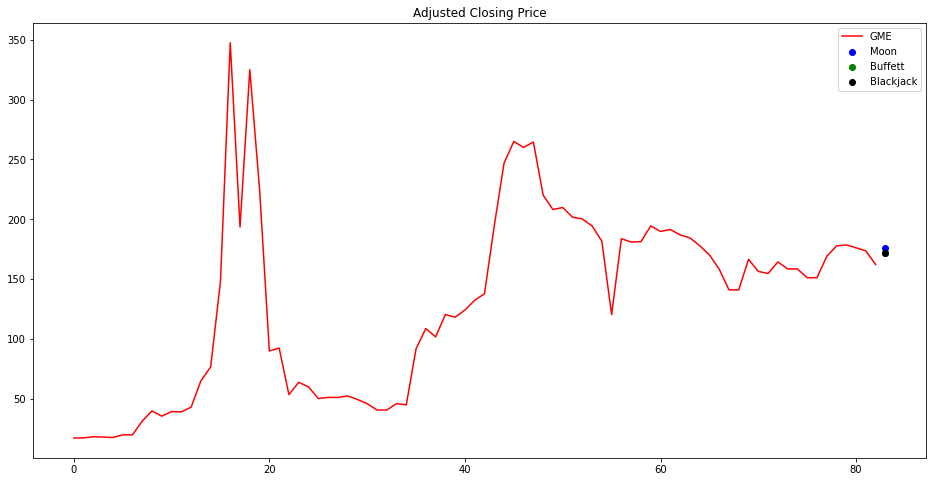

In [ ]:
graphStonks = pd.read_csv("./stonkdata.csv")
graphStonks = graphStonks.loc[::-1].reset_index(drop = True)

# print(graphStonks)
# graphStonks.head()
graphStonks['Close'].plot(label='GME', figsize=(16, 8), title='Adjusted Closing Price', color='red')
plt.scatter(len(graphStonks.index), prediction, c='blue', label='Moon')
plt.scatter(len(graphStonks.index), prePrice[0][0], c='green', label='Buffett')
plt.scatter(len(graphStonks.index), guess, c='black', label='Blackjack')
plt.legend();
print("MOON: %0.3f\nBUFFET: %0.3f\nBLACKJACK: %0.3f\nACTUAL: %0.3f" % (prediction, prePrice[0][0], guess, dateStockData['Close'][0]))